# Domain adaptation analysis

The following notebook shows a study of the classification problem of images belonging to different domains, known as domain adaptation, and the different cases with respect to the problem shown at the following link: [EGO-CH-OBJ-ADAPT](https://iplab.dmi.unict.it/EGO-CH-OBJ-ADAPT/). The proposed problem considers the case of object detection while this notebook aims to study the same problem from the point of view of image classification.

## Initial settings

#### Dependencies

In [ ]:
%pip install --user -qr ./requirements.txt

#### Imports

In [1]:
import torch
from torch import nn
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger

import torchmetrics
import torchvision
from torchvision import transforms
import torchvision.models as models

from matplotlib import pyplot as plt

import os
import numpy as np

from scripts.dataset.data_module import CulturalSiteDataModule
from scripts.models.custom_resnet_model import CustomResNetModule

#### Globals

In [ ]:
system_accelerator='gpu' #'mps' to use apple silicon graphics unit, 'gpu' for nvidia or amd
global_resnet_model=models.resnet18(pretrained=False)
global_resnet_model_name='resnet18'
global_log_dir='Official_Training'
logger=""

#### Utils

In [ ]:
#IMPORTANT: used just to notify when the training is over
from scripts.utils.telegram_notifier import TelegramNotifier

TelegramNotifier().sendMessage(logger) # logger from training cell

## Models and Tasks examined

To begin with, we chose to analyse the ResNet model, of which the most popular model is considered to be ResNet50. 
It was chosen to consider the analysis of Resnet50 and ResNet18 in order to compare their results to the proposed task.

A LightningModule called ResNetModule was constructed, which allows the two models to be used via Pytorch Lightning. 
To perform analysis with different ResNet models, you should set the variable `global_resnet_model` in the cell above.

In [ ]:
from torch import nn
import torchmetrics
import torch
import pytorch_lightning as pl
import numpy as np
class CustomResNetModule(pl.LightningModule):
    def __init__(self, resnet_model, num_classes, lr=1e-3):
        super(CustomResNetModule, self).__init__()
        self.save_hyperparameters(ignore=['resnet_model'])

        self.in_features = resnet_model.fc.in_features

        # pop fully connected layer
        resnet_model._modules.pop(list(resnet_model._modules.keys())[-1])

        # feature extractor from resnet
        self.feature_extractor = nn.Sequential(resnet_model._modules)

        # classifier from resnet
        self.classifier = nn.Sequential(
            nn.Linear(self.in_features, 512),
            nn.Dropout(0.5),
            nn.Linear(512, self.hparams.num_classes)
        )
        
        self.loss_fn = nn.CrossEntropyLoss()
        
        self.train_acc = torchmetrics.Accuracy()
        self.val_acc = torchmetrics.Accuracy()
        self.test_acc = torchmetrics.Accuracy()

    def forward(self, x):
        # features extraction and reshaping to 1-dim array
        features = self.feature_extractor(x).view(x.shape[0], -1)
        return self.classifier(features)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.hparams.lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2)
        return [optimizer], [scheduler]

    def training_step(self, batch, batch_idx):        
        x, y = batch        
        preds = self.forward(x)        
        loss = self.loss_fn(preds, y)
        self.train_acc(torch.argmax(preds, dim=1), y)
        
        self.log('training/loss', loss.item(), on_epoch=True)
        self.log('training/accuracy', self.train_acc, on_epoch=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):        
        x,y = batch        
        preds = self.forward(x)        
        loss = self.loss_fn(preds, y)
        self.val_acc(torch.argmax(preds, dim=1), y)
        
        self.log('validation/loss', loss.item(), on_epoch=True)
        self.log('validation/accuracy', self.val_acc, on_epoch=True)
        
    def test_step(self, batch, batch_idx):        
        x,y = batch
        preds = self.forward(x)

        self.test_acc(torch.argmax(preds, dim=1), y)        
        self.log('test/accuracy', self.test_acc, on_epoch=True)

## Dataset preanalysis

The cell below setup the dataset. It downloads, unpacks, and extracts patches from the original dataset. It may take a while on the first execution, then it will recognize the datasets and loads them taking a relatively short time.

In [ ]:
# REQUIRED the first execution
dm = CulturalSiteDataModule(
    batch_size=32, 
    dataset_type=CulturalSiteDataModule.SYNTHETIC_DATASET, 
    num_classes=16, 
    num_workers=6)

dm.prepare_data()
dm.setup(CulturalSiteDataModule.ALL_STAGE)

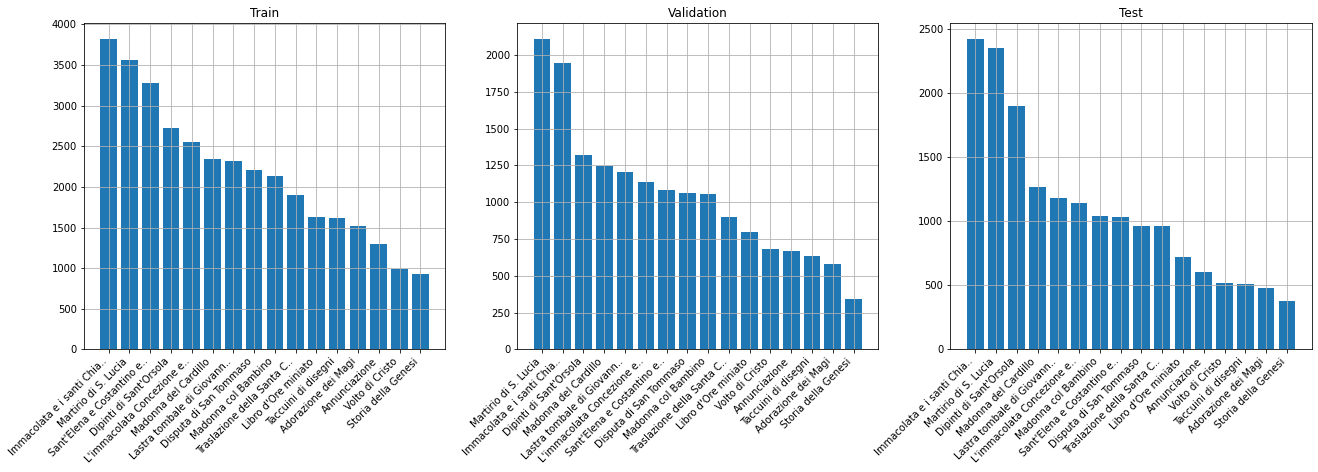

In [9]:
fig, (train_subplot, val_subplot, test_subplot) = plt.subplots(1, 3)
dm.train_preanalysis(train_subplot, 'Train')
dm.val_preanalysis(val_subplot, 'Validation')
dm.test_preanalysis(test_subplot, 'Test')
fig.set_size_inches(22, 6)
plt.show()

## 1. Filtering study case

Some patches extracted from the original dataset consist of a set of pixels that do not reflect the represented image. So we decided to analyze:

1) Training performed on the unfiltered dataset
2) Training performed on the filtered dataset (patches with less than a theshold of pixels per side are removed)

### Case 1.1: Training performed on the unfiltered dataset

#### 1.1.1 Import Dataset

In [ ]:
dm = CulturalSiteDataModule(
    batch_size=32, 
    dataset_type=CulturalSiteDataModule.SYNTHETIC_DATASET, 
    num_classes=16, 
    num_workers=6)

dm.prepare_data()
dm.setup(CulturalSiteDataModule.ALL_STAGE)

#### 1.1.2 Transform pipeline

Mean and standard deviation for normalization:

In [6]:
# OPTIONAL: does not need to be executed
mean, std = dm.calculate_train_mean_and_std(resize_min_size=256)
print("Mean: " + str(mean))
print("Std: " + str(std))

Mean: [0.27882981 0.28949824 0.31447853]
Std: [0.16738273 0.1728493  0.17549583]


In [7]:
mean=(0.27882981, 0.28949824, 0.31447853)
std=(0.16738273, 0.1728493, 0.17549583)
train_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_and_test_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),             # CenterCrop instead of RandomCrop to make the test deterministic
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

dm.set_train_trasform(train_transform)
dm.set_val_trasform(val_and_test_transform)
dm.set_test_trasform(val_and_test_transform)

#### 1.1.3 Training (no filter)

In [ ]:
lr=1e-4
model = CustomResNetModule(resnet_model=global_resnet_model, num_classes=16, lr=lr)

# Initialize logger
logger = TensorBoardLogger(
    save_dir=os.path.join("tb_logs", global_log_dir), 
    name="no_filter_train", 
    version=global_resnet_model_name + "_lr_" + str(lr))

# Initialize Callbacks
val_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="{epoch}-{step}-{validation/loss:.1f}",
    monitor="validation/loss",
    mode="min",
    save_top_k=1,
    auto_insert_metric_name=False 
)
latest_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="latest-{epoch}-{step}",
    monitor="step",
    mode="max",
    every_n_train_steps=500,
    save_top_k=1       # save just the top
)

# Initialize a trainer
trainer = pl.Trainer(max_epochs=-1,     # -1 manually stop
                     accelerator=system_accelerator,
                     devices=1,
                     logger=logger,
                     callbacks=[val_checkpoint_callback,
                                latest_checkpoint_callback],
                     )

# Train the model 
trainer.fit(model, dm)

# resume checkpoints
# trainer.fit(model, dm, ckpt_path=os.path.join(os.getcwd(), "tb_logs", "no_filter_train", "ResNet_0_lr_1e-3_m_0", "checkpoints" , "epoch=9-step=9390.ckpt"))

In [ ]:
# Evaluate the model on the held-out test set 
trainer = pl.Trainer(accelerator=system_accelerator)
model = CustomResNetModule(resnet_model=global_resnet_model, num_classes=16)
trainer.test(
    model=model,
    dataloaders=dm.test_dataloader(), 
    ckpt_path=os.path.join(os.getcwd(), "tb_logs", "no_filter_train", "ResNet_1_lr_1e-3_m_0", "checkpoints" , "epoch=14-step=16335-val_loss=0.2.ckpt"))

#### 1.1.4 Result

![ResNet Not Filtered Case](./docs/resnet_not_filtered_case.jpg)

|   Model  | Learning Rate | Accuracy   | Epochs |
|:--------:|:-------------:|:----------:|:------:|
| ResNet18 |   1e-3        |   94.46%   |   30   |
| ResNet18 |   1e-4        |   95.03%   |   50   |
| ResNet18 |   1e-5        |   91.78%   |   30   |
| ResNet50 |   1e-3        |   93.40%   |   30   |
| ResNet50 |   1e-4        |   94.95%   |   50   |
| ResNet50 |   1e-5        |   89.77%   |   30   |

### Case 1.2: Training performed on the filtered dataset
<a id='filter_case_2'></a>

Some patches extracted from the original dataset consist of a set of pixels that do not reflect the represented image. So we decided to analyze and apply a filter to cut them out.

#### 1.2.1 Import Dataset

In [ ]:
dm = CulturalSiteDataModule(
    batch_size=32, 
    dataset_type=CulturalSiteDataModule.SYNTHETIC_DATASET, 
    num_classes=16, 
    num_workers=6)

dm.prepare_data()
dm.setup(CulturalSiteDataModule.ALL_STAGE)

#### 1.2.2 Applying filter

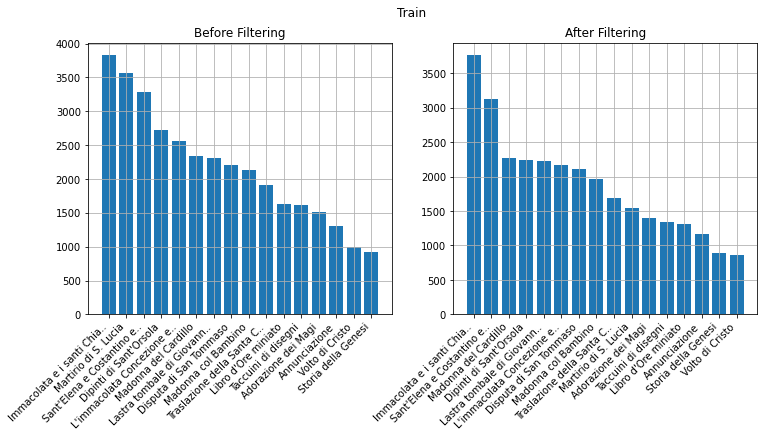

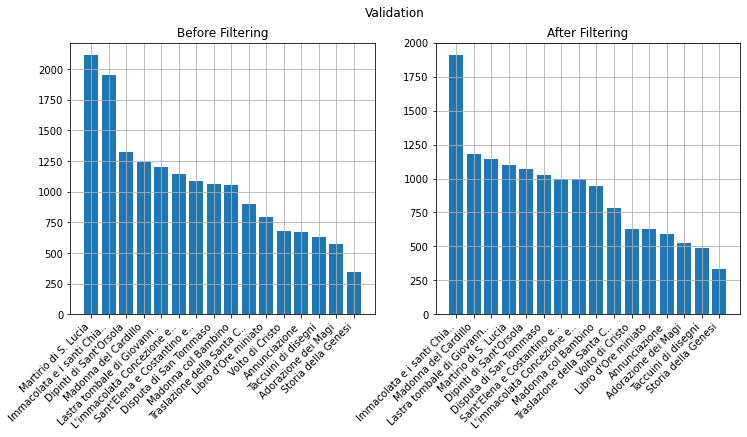

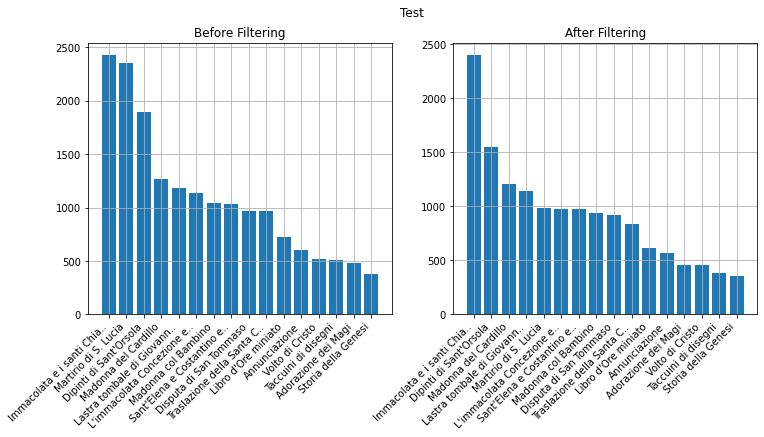

In [4]:
pixel_threshold = 30
train_fig, (train_prev_subplot, train_post_subplot) = plt.subplots(1, 2)
dm.train_preanalysis(train_prev_subplot, 'Before Filtering')
dm.filter_train(pixel_threshold)
dm.train_preanalysis(train_post_subplot, 'After Filtering')
train_fig.set_size_inches(12, 5)
train_fig.suptitle('Train')

val_fig, (val_prev_subplot, val_post_subplot) = plt.subplots(1, 2)
dm.val_preanalysis(val_prev_subplot, 'Before Filtering')
dm.filter_val(pixel_threshold)
dm.val_preanalysis(val_post_subplot, 'After Filtering')
val_fig.set_size_inches(12, 5)
val_fig.suptitle('Validation')

test_fig, (test_prev_subplot, test_post_subplot) = plt.subplots(1, 2)
dm.test_preanalysis(test_prev_subplot, 'Before Filtering')
dm.filter_test(pixel_threshold)
dm.test_preanalysis(test_post_subplot, 'After Filtering')
test_fig.set_size_inches(12, 5)
test_fig.suptitle('Test')
plt.show()

#### 1.2.3 Transform pipeline

Mean and standard deviation for normalization:

In [7]:
# OPTIONAL: does not need to be executed
mean, std = dm.calculate_train_mean_and_std(resize_min_size=256)
print("Mean: " + str(mean))
print("Std: " + str(std))

Mean: [0.28162546 0.29239721 0.31711673]
Std: [0.17125229 0.17715992 0.18002949]


In [6]:
mean=(0.28162546, 0.29239721, 0.31711673)
std=(0.17125229, 0.17715992, 0.18002949)
train_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_and_test_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),             # CenterCrop instead of RandomCrop to make the test deterministic
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

dm.set_train_trasform(train_transform)
dm.set_val_trasform(val_and_test_transform)
dm.set_test_trasform(val_and_test_transform)

#### 1.2.4 Training (filtered dataset)

In [ ]:
lr=2e-4
model = CustomResNetModule(resnet_model=global_resnet_model, num_classes=16, lr=lr)

# Initialize logger
logger = TensorBoardLogger(
    save_dir=os.path.join("tb_logs", global_log_dir), 
    name="filtered_train", 
    version=global_resnet_model_name + "_lr_" + str(lr))

val_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="{epoch}-{step}-{validation/loss:.1f}",
    monitor="validation/loss",
    mode="min",
    save_top_k=1,
    auto_insert_metric_name=False
)
latest_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="latest-{epoch}-{step}",
    monitor="step",
    mode="max",
    every_n_train_steps=500,
    save_top_k=1       # save just the top
)

# Initialize a trainer
trainer = pl.Trainer(max_epochs=50,
                     accelerator=system_accelerator,
                     devices=1,
                     logger=logger,
                     callbacks=[val_checkpoint_callback,
                                latest_checkpoint_callback],
                     )

# Train the model 
trainer.fit(model, dm)

# resume checkpoints
# trainer.fit(model, dm, ckpt_path=os.path.join(os.getcwd(), "tb_logs", "Official_Training", "filtered_train", "resnet18_lr_0.0001", "checkpoints" , "latest-epoch=29-step=28000.ckpt"))

In [ ]:
# Evaluate the model on the held-out test set 
lr=2e-4
logger = TensorBoardLogger(
    save_dir=os.path.join("tb_logs", global_log_dir), 
    name="filtered_train", 
    version=global_resnet_model_name + "_lr_" + str(lr) + "_test")
trainer = pl.Trainer(accelerator=system_accelerator, devices=1, logger=logger)
model = CustomResNetModule(resnet_model=global_resnet_model, num_classes=16)
trainer.test(
    model=model,
    dataloaders=dm.test_dataloader(), 
    ckpt_path=os.path.join(os.getcwd(), "tb_logs", "Official_Training", "filtered_train", "resnet18_lr_0.0002", "checkpoints" , "11-11268-0.1.ckpt"))

#### 1.2.5 Result

![ResNet Filtered Case](./docs/resnet_filtered_case.jpg)

The optimal learning rate with the evaluated models is 1e-4. 
ResNet18 (purple) performs slightly better during training than ResNet50 (blue) on the given task. The values of the metrics examined for the best case validation/lowest loss are shown in the following table:

So far, we have found that the filter improves both loss and accuracy of validation.


|   Model  | Learning Rate | Accuracy   | Epochs |
|:--------:|:-------------:|:----------:|:------:|
| ResNet18 |   1e-3        |   97.10%   |   30   |
| ResNet18 |   1e-4        |   98.00%   |   50   |
| ResNet18 |   1e-5        |   95.03%   |   30   |
| ResNet50 |   1e-3        |   97.10%   |   30   |
| ResNet50 |   1e-4        |   97.70%   |   50   |
| ResNet50 |   1e-5        |   93.34%   |   30   |


In view of the results obtained, it was decided to use the filtered dataset from here onwards.

## 2. Domain adaptation study cases

### 2.1 Baseline approaches without adaption
The first case of study is to train the classifier on the synthetic dataset and then test it on the real dataset, then evaluate the performance.

 ### Study Cases

#### 2.1.1 The model is trained on synthetic images and tested on synthetic images (no domain shift)

The training is the same as above. [Case 2 filtered](#filter_case_2) is taken as it returns the best results.

In [ ]:
print("Dataset setup")
dm = CulturalSiteDataModule(
    batch_size=32, 
    dataset_type=CulturalSiteDataModule.SYNTHETIC_DATASET, 
    num_classes=16, 
    num_workers=6)

dm.prepare_data()
dm.setup(CulturalSiteDataModule.TEST_STAGE)

print("Dataset applying filter")
pixel_threshold = 30
dm.filter_test(pixel_threshold)

print("Dataset set transform")
val_and_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.28162546, 0.29239721, 0.31711673), std=(0.17125229, 0.17715992, 0.18002949))
])
dm.set_test_trasform(val_and_test_transform)


In [ ]:
trainer = pl.Trainer(accelerator=system_accelerator)
model = CustomResNetModule(model=global_resnet_model, num_classes=16, lr=1e-4)
trainer.test(
    model=model,
    dataloaders=dm.test_dataloader(), 
    ckpt_path=os.path.join(os.getcwd(), "tb_logs", "filtered_train", "ResNet_0_lr_1e-4_m_0", "checkpoints" , "epoch=17-step=16902-val_loss=0.1.ckpt"))

 #### 2.1.1.1 Result

Perfomance analysis are the same as above in [Case 2 filtered](#filter_case_2).

#### 2.1.2 The model is trained on synthetic images and tested on real images (no adaptation)

In [ ]:
print("Dataset setup")
dm = CulturalSiteDataModule(
    batch_size=32, 
    dataset_type=CulturalSiteDataModule.REAL_DATASET, 
    num_classes=16, 
    num_workers=6)

dm.prepare_data()
dm.setup(CulturalSiteDataModule.TEST_STAGE)

print("Dataset applying filter")
test_fig, (test_prev_subplot, test_post_subplot) = plt.subplots(1, 2)
dm.test_preanalysis(test_prev_subplot, 'Before Filtering')
dm.filter_test(pixel_threshold=30)
dm.test_preanalysis(test_post_subplot, 'After Filtering')
test_fig.set_size_inches(12, 5)
test_fig.suptitle('Test')

print("Dataset set transform")
val_and_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.28162546, 0.29239721, 0.31711673), std=(0.17125229, 0.17715992, 0.18002949))
])

dm.set_test_trasform(val_and_test_transform)
plt.show()

In [ ]:
trainer = pl.Trainer(accelerator=system_accelerator)
model = CustomResNetModule(model=global_resnet_model, num_classes=16, lr=1e-4)
trainer.test(
    model=model,
    dataloaders=dm.test_dataloader(), 
    ckpt_path=os.path.join(os.getcwd(), "tb_logs", "filtered_train", "ResNet_0_lr_1e-4_m_0", "checkpoints" , "epoch=17-step=16902-val_loss=0.1.ckpt"))

 #### 2.1.2.1 Result

|   Model  | Learning Rate | Accuracy   | Epochs   |
|:--------:|:-------------:|:----------:|:--------:|
| ResNet18 |   1e-4        |   2.96%    |   50     |
| ResNet50 |   1e-4        |   2.55%    |   50     |

#### 2.1.3 The model is trained on real images and tested on real images (Oracle)

In [ ]:
dm = CulturalSiteDataModule(
    batch_size=32, 
    dataset_type=CulturalSiteDataModule.REAL_DATASET, 
    num_classes=16, 
    num_workers=6)

dm.prepare_data()
dm.setup(CulturalSiteDataModule.ALL_STAGE)

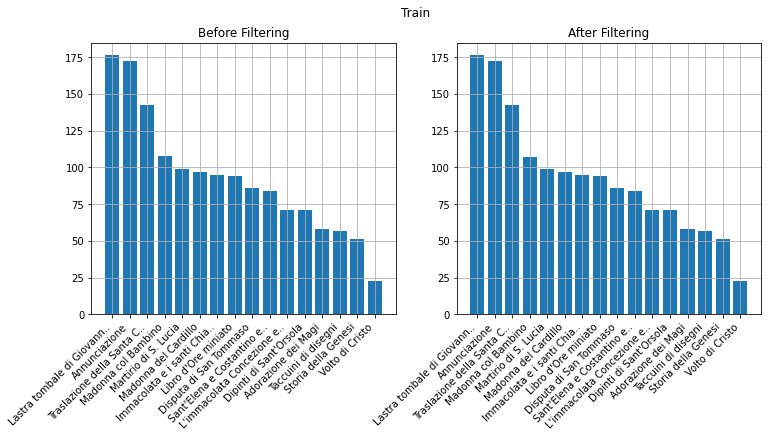

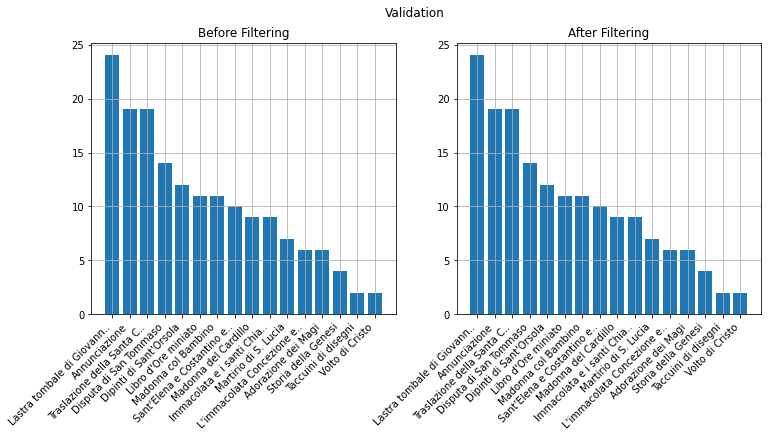

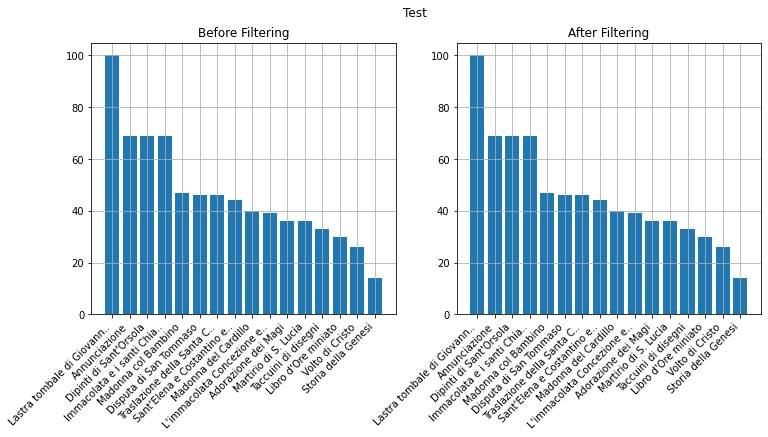

In [4]:
pixel_threshold = 30
train_fig, (train_prev_subplot, train_post_subplot) = plt.subplots(1, 2)
dm.train_preanalysis(train_prev_subplot, 'Before Filtering')
dm.filter_train(pixel_threshold)
dm.train_preanalysis(train_post_subplot, 'After Filtering')
train_fig.set_size_inches(12, 5)
train_fig.suptitle('Train')

val_fig, (val_prev_subplot, val_post_subplot) = plt.subplots(1, 2)
dm.val_preanalysis(val_prev_subplot, 'Before Filtering')
dm.filter_val(pixel_threshold)
dm.val_preanalysis(val_post_subplot, 'After Filtering')
val_fig.set_size_inches(12, 5)
val_fig.suptitle('Validation')

test_fig, (test_prev_subplot, test_post_subplot) = plt.subplots(1, 2)
dm.test_preanalysis(test_prev_subplot, 'Before Filtering')
dm.filter_test(pixel_threshold)
dm.test_preanalysis(test_post_subplot, 'After Filtering')
test_fig.set_size_inches(12, 5)
test_fig.suptitle('Test')
plt.show()

In [5]:
# OPTIONAL: does not need to be executed
mean, std = dm.calculate_train_mean_and_std(resize_min_size=256)
print("Mean: " + str(mean))
print("Std: " + str(std))

Mean: [0.45401238 0.39960463 0.31759819]
Std: [0.26222476 0.25603036 0.25329951]


In [5]:
mean=(0.45401238, 0.39960463, 0.31759819)
std=(0.26222476, 0.25603036, 0.25329951)
train_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_and_test_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224), 
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

dm.set_train_trasform(train_transform)
dm.set_val_trasform(val_and_test_transform)
dm.set_test_trasform(val_and_test_transform)

In [ ]:
lr=1e-4
model = CustomResNetModule(resnet_model=global_resnet_model, num_classes=16, lr=lr)

# Initialize logger
logger = TensorBoardLogger(
    save_dir=os.path.join("tb_logs", global_log_dir), 
    name="baseline_appr_3_real", 
    version=global_resnet_model_name + "_lr_" + str(lr))

val_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="{epoch}-{step}-{validation/loss:.1f}",
    monitor="validation/loss",
    mode="min",
    save_top_k=1,
    auto_insert_metric_name=False      
)
latest_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="latest-{epoch}-{step}",
    monitor="step",
    mode="max",
    every_n_train_steps=500,
    save_top_k=1       # save just the top
)

# Initialize a trainer
trainer = pl.Trainer(max_epochs=500,     
                     accelerator=system_accelerator,
                     devices=1,
                     logger=logger,
                     callbacks=[val_checkpoint_callback,
                                latest_checkpoint_callback],
                     )

# Train the model 
# trainer.fit(model, dm)

# Resume checkpoints
trainer.fit(model, dm, ckpt_path=os.path.join(os.getcwd(), "tb_logs", "Official_Training", "baseline_appr_3_real", "resnet18_lr_0.0001", "checkpoints" , "latest-epoch=42-step=2000.ckpt"))

In [ ]:
trainer = pl.Trainer(accelerator=system_accelerator)
model = CustomResNetModule(resnet_model=global_resnet_model, num_classes=16)
trainer.test(
    model=model,
    dataloaders=dm.test_dataloader(), 
    ckpt_path=os.path.join(os.getcwd(), "tb_logs", "Official_Training", "baseline_appr_3_real", "resnet18_lr_0.0001", "checkpoints" , "405-19082-1.2.ckpt"))

 #### 2.1.3.1 Result

|   Model  | Learning Rate | Accuracy    | Epochs   |
|:--------:|:-------------:|:-----------:|:--------:|
| ResNet18 |   1e-4        |   60.75%    |   500    |
| ResNet50 |   1e-4        |   48.52%    |   500    |

### 2.2 Domain adaptation through image-to-image translation (CycleGAN)

![CycleGAN](./docs/cycle_gan.png)

This section aims to apply image-to-image translation through CycleGAN PyTorch lightning implementation, building a pipeline to concatenate CycleGAN translated image between real and synthetic domains with ResNetModule. It is going to show 2 case of study:

1) Make the classifier use CycleGAN **real->synthetic** domain images during inference (**trained** using **synthetic domain** images).
2) Make the classifier use CycleGAN **synthetic->real** domain images during the training.

#### 2.2.1 CycleGAN Model

This section shows the CycleGAN PyTorch lightning implementation and how it is trained for pixel-level image-to-image translation.

In [3]:
import pytorch_lightning as pl
import itertools
import torchvision
from scripts.CycleGAN.generator import Generator
from scripts.CycleGAN.discriminator import Discriminator
from scripts.CycleGAN.utils import weights_init_normal, LambdaLR

class CycleGAN(pl.LightningModule):

    A2B = 0
    B2A = 1

    def __init__(self, 
                 input_nc = 3, 
                 output_nc = 3, 
                 lr=0.0002, 
                 betas=(0.5, 0.999), 
                 starting_epoch=0, 
                 n_epochs=200, 
                 decay_epoch=100,
                 print_images_each_N_batch = 500
                  ):
        super(CycleGAN, self).__init__()
        self.save_hyperparameters()
        
        # Generators A2B, B2A
        self.netG_A2B = Generator(input_nc, output_nc)
        self.netG_B2A = Generator(output_nc, input_nc)
        
        # A and B Discriminator
        self.netD_A = Discriminator(input_nc)
        self.netD_B = Discriminator(output_nc)
        
        # Normalization
        self.netG_A2B.apply(weights_init_normal)
        self.netG_B2A.apply(weights_init_normal)
        self.netD_A.apply(weights_init_normal)
        self.netD_B.apply(weights_init_normal)
        
        # Losses
        self.criterion_GAN = torch.nn.MSELoss()
        self.criterion_cycle = torch.nn.L1Loss()
        self.criterion_identity = torch.nn.L1Loss()
                    
    def forward(self, x, mode=A2B):
        if mode== CycleGAN.A2B:
            return self.netG_A2B(x)
        else:
            return self.netG_B2A(x)
    
    def configure_optimizers(self):
        # Generator Optimizer
        optimizer_G = torch.optim.Adam(itertools.chain(self.netG_A2B.parameters(), self.netG_B2A.parameters()), lr=self.hparams.lr, betas=self.hparams.betas)
        
        # Discriminator Optimizers
        optimizer_D_A = torch.optim.Adam(self.netD_A.parameters(), lr=self.hparams.lr, betas=self.hparams.betas)
        optimizer_D_B = torch.optim.Adam(self.netD_B.parameters(), lr=self.hparams.lr, betas=self.hparams.betas)
        
        # Scheduler learning rate decay
        lr_scheduler_G = torch.optim.lr_scheduler.LambdaLR(optimizer_G, lr_lambda=LambdaLR(self.hparams.n_epochs, self.hparams.starting_epoch, self.hparams.decay_epoch).step)
        lr_scheduler_D_A = torch.optim.lr_scheduler.LambdaLR(optimizer_D_A, lr_lambda=LambdaLR(self.hparams.n_epochs, self.hparams.starting_epoch, self.hparams.decay_epoch).step)
        lr_scheduler_D_B = torch.optim.lr_scheduler.LambdaLR(optimizer_D_B, lr_lambda=LambdaLR(self.hparams.n_epochs, self.hparams.starting_epoch, self.hparams.decay_epoch).step)
        
        return [optimizer_G, optimizer_D_A, optimizer_D_B], [lr_scheduler_G, lr_scheduler_D_A, lr_scheduler_D_B]
    
    
    def training_step(self, batch, batch_idx, optimizer_idx):
        real_A, real_B = batch
        
        target_real = torch.ones((real_A.shape[0],1)).type_as(real_A)
        target_fake = torch.zeros((real_A.shape[0],1)).type_as(real_A)
        
        # Generator
        if optimizer_idx==0:
            # Identity loss
            # G_A2B(B) should equal B if real B is fed
            same_B = self.netG_A2B(real_B)
            loss_identity_B = self.criterion_identity(same_B, real_B)*5.0

            # G_B2A(A) should equal A if real A is fed
            same_A = self.netG_B2A(real_A)
            loss_identity_A = self.criterion_identity(same_A, real_A)*5.0

            # GAN loss
            fake_B = self.netG_A2B(real_A) 
            pred_fake = self.netD_B(fake_B) # discriminator B prediction
            loss_GAN_A2B = self.criterion_GAN(pred_fake, target_real) # loss GAN A2B

            fake_A = self.netG_B2A(real_B)
            pred_fake = self.netD_A(fake_A)  # discriminator A prediction
            loss_GAN_B2A = self.criterion_GAN(pred_fake, target_real) # loss GAN B2A

            # Cycle consistency loss
            recovered_A = self.netG_B2A(fake_B) #fake B -> B2A - should be same as real_A
            loss_cycle_ABA = self.criterion_cycle(recovered_A, real_A)*10.0 #cycle consistency loss

            recovered_B = self.netG_A2B(fake_A) #fake A -> A2B - should be same as real_B
            loss_cycle_BAB = self.criterion_cycle(recovered_B, real_B)*10.0 #cycle consistency loss

            # Overall loss
            loss_G = loss_identity_A + loss_identity_B + loss_GAN_A2B + loss_GAN_B2A + loss_cycle_ABA + loss_cycle_BAB
            self.log('loss_G/loss_identity_A', loss_identity_A, on_epoch=True)
            self.log('loss_G/loss_identity_B', loss_identity_B, on_epoch=True)
            self.log('loss_G/loss_GAN_A2B', loss_GAN_A2B, on_epoch=True)
            self.log('loss_G/loss_GAN_B2A', loss_GAN_B2A, on_epoch=True)
            self.log('loss_G/loss_cycle_ABA', loss_cycle_ABA, on_epoch=True)
            self.log('loss_G/loss_cycle_BAB', loss_cycle_BAB, on_epoch=True)
            self.log('loss_G/overall', loss_G, on_epoch=True)
            
            # Log images to visually check the trainig
            if batch_idx % self.hparams.print_images_each_N_batch == 0:
                grid_A = torchvision.utils.make_grid(real_A[:50], nrow=10, normalize=True)
                grid_A2B = torchvision.utils.make_grid(fake_B[:50], nrow=10, normalize=True)
                grid_A2B2A = torchvision.utils.make_grid(recovered_A[:50], nrow=10, normalize=True)
                
                grid_B = torchvision.utils.make_grid(real_B[:50], nrow=10, normalize=True)
                grid_B2A = torchvision.utils.make_grid(fake_A[:50], nrow=10, normalize=True)
                grid_B2A2B = torchvision.utils.make_grid(recovered_B[:50], nrow=10, normalize=True)
                
                self.logger.experiment.add_image('A/A', grid_A, self.global_step)
                self.logger.experiment.add_image('A/A2B', grid_A2B, self.global_step)
                self.logger.experiment.add_image('A/A2B2A', grid_A2B2A, self.global_step)
                
                self.logger.experiment.add_image('B/B', grid_B, self.global_step)
                self.logger.experiment.add_image('B/B2A', grid_B2A, self.global_step)
                self.logger.experiment.add_image('B/B2A2B', grid_B2A2B, self.global_step)
                
            return loss_G
        
        # Discriminator A
        elif optimizer_idx==1:
            # Real loss
            pred_real = self.netD_A(real_A)
            loss_D_real = self.criterion_GAN(pred_real, target_real)

            # Fake loss
            fake_A = self.netG_B2A(real_B)
            pred_fake = self.netD_A(fake_A.detach())
            loss_D_fake = self.criterion_GAN(pred_fake, target_fake)

            # loss globale
            loss_D_A = (loss_D_real + loss_D_fake)*0.5
            self.log('loss_D/loss_D_A',loss_D_A, on_epoch=True)
            return loss_D_A
        
        # Discriminator B
        elif optimizer_idx==2:
            pred_real = self.netD_B(real_B)
            loss_D_real = self.criterion_GAN(pred_real, target_real)

            # Fake loss
            fake_B = self.netG_A2B(real_A) 
            pred_fake = self.netD_B(fake_B.detach())
            loss_D_fake = self.criterion_GAN(pred_fake, target_fake)

            # loss globale
            loss_D_B = (loss_D_real + loss_D_fake)*0.5
            self.log('loss_D/loss_D_B', loss_D_B, on_epoch=True)
            return loss_D_B

##### 2.2.1.1 Import Dataset

In [4]:
from scripts.dataset.GAN.data_module_GAN import CulturalSiteDataModuleGAN

batch_size = 2
dm = CulturalSiteDataModuleGAN(
    batch_size=batch_size, 
    num_workers=6)
dm.setup(CulturalSiteDataModuleGAN.ALL_STAGE)
pixel_threshold = 30
dm.filter_train(pixel_threshold)
dm.filter_test(pixel_threshold)

##### 2.2.1.2 Training

In [ ]:
lr=2e-4
model = CycleGAN(batch_size=batch_size, lr=lr)

# Initialize logger
logger = TensorBoardLogger(
    save_dir=os.path.join("tb_logs", global_log_dir), 
    name="image_to_image_translation", 
    version="CycleGAN_lr_" + str(lr))

overall_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="{epoch}-{step}-{loss_G/overall:.1f}",
    monitor="loss_G/overall",
    mode="min",
    save_top_k=1,
    auto_insert_metric_name=False      
)
latest_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="latest-{epoch}-{step}",
    monitor="step",
    mode="max",
    every_n_train_steps=500,
    save_top_k=1       
)

# Initialize a trainer
trainer = pl.Trainer(max_epochs=-1, 
                     accelerator=system_accelerator,
                     devices=1,
                     logger=logger,
                     callbacks=[ overall_checkpoint_callback, latest_checkpoint_callback],
                     )

# Train the model 
trainer.fit(model, dm)

# resume checkpoints
# trainer.fit(model, dm, ckpt_path=os.path.join(os.getcwd(), "tb_logs", "no_filter_train", "ResNet_0_lr_1e-3_m_0", "checkpoints" , "epoch=9-step=9390.ckpt"))

### Discriminator

![CycleGAN Discriminator](docs/DiscriminatorCycleGAN.jpg)


### Generator

![GeneratorCycleGAN_1](docs/GeneratorCycleGAN_1.jpg) 

![GeneratorCycleGAN_2](docs/GeneratorCycleGAN_2.jpg) 

#### 2.2.2 Case 1: Testing CycleGAN and ResNet (real->synthetic->inference)

Il modulo sotto implementa l'unione dei due modelli CycleGAN e ResNet, effettuando una traduzione dell'immagine reale -> synthetic e poi facendo inferenza con ResNet.

In [8]:
from scripts.CycleGAN.model import CycleGAN

class CycleGANResNetPretrainedModule(pl.LightningModule):
    
    def __init__(self, cycle_GAN_ckpt_path, res_net_ckpt_path):
        super(CycleGANResNetPretrainedModule, self).__init__()
        self.CycleGAN_model = CycleGAN.load_from_checkpoint(cycle_GAN_ckpt_path)
        self.CycleGAN_model.eval()
        self.ResNet_model = CustomResNetModule.load_from_checkpoint(res_net_ckpt_path)

        self.test_acc = torchmetrics.Accuracy()

    def forward(self, x): # x = real_B
        fake_A = self.CycleGAN_model(x, CycleGAN.B2A)
        self.print_images(x, fake_A)
        return self.ResNet_model(fake_A)

    def print_images(self, x, fake_A):
        grid_A = torchvision.utils.make_grid(x[:50], nrow=10, normalize=True)
        grid_A2B = torchvision.utils.make_grid(fake_A[:50], nrow=10, normalize=True)

        self.logger.experiment.add_image('A/A', grid_A, self.batch_idx)
        self.logger.experiment.add_image('A/A2B', grid_A2B, self.batch_idx)
        
    def test_step(self, batch, batch_idx):
        x,y = batch
        self.batch_idx = batch_idx
        preds = self.forward(x)
        self.test_acc(torch.argmax(preds, dim=1), y)
        
        self.log('test/accuracy', self.test_acc)       

 ##### 2.2.2.1 Dataset Setup

In [ ]:
print("Dataset setup")
dm = CulturalSiteDataModule(
    batch_size=2, 
    dataset_type=CulturalSiteDataModule.REAL_DATASET, 
    num_classes=16, 
    num_workers=6)
    
dm.setup(CulturalSiteDataModule.TEST_STAGE)

print("Dataset applying filter")
dm.filter_test(pixel_threshold=30)

print("Dataset set transform")
val_and_test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.28162546, 0.29239721, 0.31711673), std=(0.17125229, 0.17715992, 0.18002949))
])

dm.set_test_trasform(val_and_test_transform)

 ##### 2.2.2.2 Testing

In [ ]:
logger = TensorBoardLogger(
    save_dir=os.path.join("tb_logs", global_log_dir, "image_to_image_translation"), 
    name="case_1_real_syn_inference", 
    version=global_resnet_model_name + "_lr_" + str(lr))

trainer = pl.Trainer(accelerator=system_accelerator, logger=logger)
model = CycleGANResNetPretrainedModule(
    cycle_GAN_ckpt_path=os.path.join(os.getcwd(), "tb_logs", "image_to_image_translation", "CycleGAN_0_lr_0.0002", "checkpoints" , "epoch=0-step=45051-val_loss=0.0.ckpt"),
    res_net_ckpt_path=os.path.join(os.getcwd(), "tb_logs", "filtered_train", "ResNet_0_lr_1e-4_m_0", "checkpoints" , "epoch=17-step=16902-val_loss=0.1.ckpt"))
    
trainer.test(
    model=model,
    dataloaders=dm.test_dataloader())

##### 2.2.2.3 Result

|   Model             | Accuracy   |
|:-------------------:|:----------:|
| CycleGAN + ResNet18 |   10.22%   |
| CycleGAN + ResNet50 |   9.81%    |

#### 2.2.3 Case 2: Training ResNet with CycleGAN translated images (synthetic->real->training)

In this section, we combine CycleGAN translated image dataset (synthetic->real) with ResNet, which is being trained using the real domain.

##### 2.2.3.1 Model

In [4]:
from scripts.CycleGAN.model import CycleGAN

class CycleGANResNetModule(pl.LightningModule):
    
    def __init__(self, cycle_GAN_ckpt_path, resnet_model, num_classes = 16, lr=1e-4):
        super(CycleGANResNetModule, self).__init__()
        self.num_classes = num_classes
        self.lr = lr
        
        self.CycleGAN_model = CycleGAN.load_from_checkpoint(cycle_GAN_ckpt_path)
        self.CycleGAN_model.eval()

        self.ResNet_model = CustomResNetModule(resnet_model=resnet_model, num_classes=num_classes, lr=lr)
        
        self.loss_fn = nn.CrossEntropyLoss()
        
        self.train_acc = torchmetrics.Accuracy()
        self.val_acc = torchmetrics.Accuracy()
        self.test_acc = torchmetrics.Accuracy()
        
    def forward_cycleGAN(self, x): # x = real_A
        fake_B = self.CycleGAN_model(x, CycleGAN.A2B)
        # self.print_images(x, fake_B)
        return self.ResNet_model(fake_B)

    def forward(self, x): # x = real_A
        return self.ResNet_model(x)
            
    def print_images(self, x, fake_A):
        grid_A = torchvision.utils.make_grid(x[:50], nrow=10, normalize=True)
        grid_A2B = torchvision.utils.make_grid(fake_A[:50], nrow=10, normalize=True)

        self.logger.experiment.add_image('A/A', grid_A, self.batch_idx)
        self.logger.experiment.add_image('A/A2B', grid_A2B, self.batch_idx)
    
    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.lr)
        scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2)
        return [optimizer], [scheduler]
    
    def training_step(self, batch, batch_idx):   
        self.batch_idx = batch_idx
        x, y = batch        
        preds = self.forward_cycleGAN(x)        
        loss = self.loss_fn(preds, y)
        self.train_acc(torch.argmax(preds, dim=1), y)
        
        self.log('training/loss', loss.item(), on_epoch=True)
        self.log('training/accuracy', self.train_acc, on_epoch=True)
        
        return loss
    
    def validation_step(self, batch, batch_idx):        
        self.batch_idx = batch_idx
        x,y = batch        
        preds = self.forward(x)        
        loss = self.loss_fn(preds, y)
        self.val_acc(torch.argmax(preds, dim=1), y)
        
        self.log('validation/loss', loss.item(), on_epoch=True)
        self.log('validation/accuracy', self.val_acc, on_epoch=True)
        
    def test_step(self, batch, batch_idx):        
        x,y = batch
        preds = self.forward(x)
        self.test_acc(torch.argmax(preds, dim=1), y)
        
        self.log('test/accuracy', self.test_acc, on_epoch=True)

##### 2.2.3.2 Synthetic dataset setup

In [ ]:
print("Dataset setup")
dm = CulturalSiteDataModule(
    batch_size=8, 
    dataset_type=CulturalSiteDataModule.SYNTHETIC_REAL_DATASET, 
    num_classes=16, 
    num_workers=6)
dm.setup(CulturalSiteDataModule.ALL_STAGE)

print("Dataset applying filter")
pixel_threshold = 30
dm.filter_train(pixel_threshold)
dm.filter_val(pixel_threshold)

In [6]:
# Coming from baseline case 3 oracle
mean=(0.45401238, 0.39960463, 0.31759819)
std=(0.26222476, 0.25603036, 0.25329951)
train_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_and_test_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),            
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

dm.set_train_trasform(train_transform)
dm.set_val_trasform(val_and_test_transform)

##### 2.2.3.3 Training

In [ ]:
lr=4e-4
model = CycleGANResNetModule(
        cycle_GAN_ckpt_path=os.path.join(os.getcwd(), "tb_logs", "image_to_image_translation", "CycleGAN_2_lr_0.0004", "checkpoints" , "latest-epoch=8-step=400500.ckpt"),
        num_classes=16,
        resnet_model= global_resnet_model,
        lr=lr)

# Initialize logger
logger = TensorBoardLogger(
    save_dir=os.path.join("tb_logs", global_log_dir, "image_to_image_translation"), 
    name="case_2_syn_real_training", 
    version=global_resnet_model_name + "_lr_" + str(lr))

val_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="{epoch}-{step}-{validation/loss:.1f}",
    monitor="validation/loss",
    mode="min",
    save_top_k=1,
    auto_insert_metric_name=False    
)
latest_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="latest-{epoch}-{step}",
    monitor="step",
    mode="max",
    every_n_train_steps=500,
    save_top_k=1
)

# Initialize a trainer
trainer = pl.Trainer(max_epochs=-1,    
                     accelerator=system_accelerator, 
                     devices=1,
                     logger=logger,
                     callbacks=[ val_checkpoint_callback, latest_checkpoint_callback],
                     )

# Train the model 
trainer.fit(model, dm)

# resume checkpoints
# trainer.fit(model, dm, ckpt_path=os.path.join(os.getcwd(), "tb_logs", "image_to_image_translation", "CycleGANResNetModule_0_lr_0.0001", "checkpoints" , "latest-epoch=7-step=29000.ckpt"))

##### 2.2.3.3 Testing

Real dataset setup

In [ ]:
print("Dataset setup")
dm = CulturalSiteDataModule(
    batch_size=8, 
    dataset_type=CulturalSiteDataModule.REAL_DATASET, 
    num_classes=16, 
    num_workers=6)
dm.setup(CulturalSiteDataModule.TEST_STAGE)

print("Dataset applying filter")
pixel_threshold = 30
dm.filter_test(pixel_threshold)

In [5]:
# Coming from baseline case 3 oracle
mean=(0.45401238, 0.39960463, 0.31759819)
std=(0.26222476, 0.25603036, 0.25329951)
test_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),            
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
dm.set_test_trasform(test_transform)

In [ ]:
# Evaluate the model on the held-out test set 
trainer = pl.Trainer(accelerator=system_accelerator)
model = CycleGANResNetModule(
        cycle_GAN_ckpt_path=os.path.join(os.getcwd(), "tb_logs", "image_to_image_translation", "CycleGAN_2_lr_0.0004", "checkpoints" , "latest-epoch=6-step=274500.ckpt"),
        num_classes=16,
        ResNet_model= global_resnet_model)
trainer.test(
    model=model,
    dataloaders=dm.test_dataloader(), 
    ckpt_path=os.path.join(os.getcwd(), "tb_logs", "image_to_image_translation", "CycleGANResNetModule_0_lr_0.0001", "checkpoints" , "latest-epoch=7-step=29000.ckpt"))

##### 2.2.3.3 Result

![Synthetic_Real_Training_1](docs/Synthetic_Real_Training_1.jpg)
![Synthetic_Real_Training_2](docs/Synthetic_Real_Training_2.jpg)

|   Model             | Learning Rate    | Accuracy    | Epochs   |
|:-------------------:|:----------------:|:-----------:|:--------:|
| CycleGAN + ResNet18 |   1e-4           |   18.82%    |   15     |
| CycleGAN + ResNet18 |   2.5e-05        |   24.46%    |   15     |
| CycleGAN + ResNet18 |   2.5e-06        |   13.17%    |   10     |
| CycleGAN + ResNet18 |   1.5e-05        |   15.59%    |   15     |
| CycleGAN + ResNet18 |   3.5e-05        |   22.18%    |   15     |

### 2.3 Feature-level Domain Adaptation

#### 2.3.1 Gradient Reversal layer

![Gradient Reversal Layer](./docs/gradient_reversal_layer.png)

The principle is simple:
- Feature Extractor (green): Extract features from the two domains
- Label predictor (blue): Classifies against the labels of the individual domains
- Domain classifier (pink): Classifies and recognises which domain the image belongs to

The loss is composed as follows: 

$$ L = L_y - \lambda L_d $$

$ L_y $ is the loss of the label predictor, $ L_d $ is the loss of the domain classifier. Intuitively one wants to minimise the former, but maximise the latter, so that the domain at the feature level is no longer distinguished.

$ \lambda $ is calculated during training according to the following formula:

$$ \lambda_p = \frac{2}{1 + e^{-\gamma  p}} - 1 $$

$ \gamma = 10 $ e $ p \in [0, 1] $ (calculated as `current_epoch/number_of_epochs`).

Definition of the gradient reversal layer task comprising the GRL module and domain discriminator

##### 3.1.1 Training

In [3]:
NUM_EPOCHS=50

Model

In [4]:
from scripts.GRL.domain_discriminator import DomainDiscriminatorGRL
import numpy as np
import torch.nn.functional as F
from torch import nn

class DomainAdaptationGRLTask(pl.LightningModule):
    def __init__(self, model, lr=1e-3):
        super(DomainAdaptationGRLTask, self).__init__() 
        self.lr = lr
        self.model = model
        self.discriminator = DomainDiscriminatorGRL(in_features=model.in_features)

        self.cross_entropy_loss = nn.CrossEntropyLoss()
        self.bce_loss = nn.BCEWithLogitsLoss()

        self.val_acc =  torchmetrics.Accuracy()
        self.test_acc =  torchmetrics.Accuracy()

    def forward(self,x):
        return self.model(x)

    def configure_optimizers(self):
        return torch.optim.Adam(list(self.model.parameters()) + list(self.discriminator.parameters()), lr=self.lr)
       
    def training_step(self, train_batch, batch_idx):
        source, target, labels = train_batch

        # grid_source = torchvision.utils.make_grid(source[:50], nrow=10, normalize=True)
        # self.logger.experiment.add_image('source', grid_source, batch_idx)

        # grid_target = torchvision.utils.make_grid(target[:50], nrow=10, normalize=True)
        # self.logger.experiment.add_image('target', grid_target, batch_idx)
        
        source_features = self.model.feature_extractor(source).view(source.shape[0], -1)
        target_features = self.model.feature_extractor(target).view(target.shape[0], -1)
        label_preds = self.model.classifier(source_features)

        # getting lambda val using original paper, from 0 to 1 following this formula
        lamb=2/(1+np.exp(-10*self.current_epoch/NUM_EPOCHS)) - 1

        domain_preds_source = self.discriminator(source_features, lamb)
        domain_preds_target = self.discriminator(target_features, lamb)
        domain_preds = torch.cat([domain_preds_source, domain_preds_target],0)

        source_acc = (torch.sigmoid(domain_preds_source)<0.5).float().mean()
        target_acc = (torch.sigmoid(domain_preds_target)>=0.5).float().mean()
        acc = (source_acc+target_acc)/2

        source_targets = torch.zeros(source.shape[0],1)
        target_targets = torch.ones(target.shape[0],1)
        domain_targets = torch.cat([source_targets, target_targets],0).type_as(source)

        label_loss = self.cross_entropy_loss(label_preds, labels)
        domain_loss = self.bce_loss(domain_preds, domain_targets)
        loss = domain_loss + label_loss

        self.log('train/domain_loss', domain_loss)
        self.log('train/label_loss', label_loss)
        self.log('train/loss', loss)
        self.log('train/disc_source_acc',source_acc)
        self.log('train/disc_target_acc',target_acc)
        self.log('train/disc_acc',acc)
        return loss

    def validation_step(self, batch, batch_idx):        
        x,y = batch        
        preds = self.forward(x)        
        self.val_acc(torch.argmax(preds, dim=1), y)

        self.log('validation/accuracy', self.val_acc, on_epoch=True)
        
    def test_step(self, batch, batch_idx):        
        x,y = batch
        preds = self.forward(x)
        self.test_acc(torch.argmax(preds, dim=1), y)
        
        self.log('test/accuracy', self.test_acc, on_epoch=True)

Dataset Setup

In [ ]:
from scripts.dataset.GRL.data_module_GRL import CulturalSiteDataModuleGRL

print("Dataset setup")
dm = CulturalSiteDataModuleGRL(
    batch_size=32, 
    num_workers=6)
dm.setup(CulturalSiteDataModuleGRL.FIT_STAGE)

print("Dataset applying filter")
pixel_threshold = 30
dm.filter_train(pixel_threshold)
dm.filter_val(pixel_threshold)

Normalization

Using zero-mean-nomalization, the cells below calculate mean and std for individual or merged datasets to implement a case of study where:
1. normalization using individual mean and std
2. normalization using global mean and std

In [6]:
syn_img_dataset = np.array(dm.cultural_site_train.get_syn_image_dataset())[:,1]
real_img_dataset = np.array(dm.cultural_site_train.get_real_image_dataset())[:,1]
merged_dataset = np.concatenate((syn_img_dataset, real_img_dataset))

Getting mean and std for synthetic dataset

In [ ]:
# OPTIONAL: does not need to be executed
mean, std = dm.calculate_train_mean_and_std(resize_min_size=256, img_dataset=syn_img_dataset)
print("Mean: " + str(mean))
print("Std: " + str(std))

Mean: [0.28162546 0.29239721 0.31711673]
Std: [0.17125229 0.17715992 0.18002949]


Getting mean and std for real dataset

In [ ]:
# OPTIONAL: does not need to be executed
mean, std = dm.calculate_train_mean_and_std(resize_min_size=256, img_dataset=real_img_dataset)
print("Mean: " + str(mean))
print("Std: " + str(std))

Mean: [0.45215473 0.39806145 0.31654662]
Std: [0.26077601 0.25441129 0.25139287]


Getting mean and std for merged dataset

In [7]:
# OPTIONAL: does not need to be executed
mean, std = dm.calculate_train_mean_and_std(resize_min_size=256, img_dataset=merged_dataset)
print("Mean: " + str(mean))
print("Std: " + str(std))

Mean: [0.28954191 0.29725961 0.31696455]
Std: [0.18010984 0.18290568 0.18407021]


Global transform pipeline

In [6]:
# Coming from cell above
mean=(0.28954191, 0.29725961, 0.31696455)
std=(0.18010984, 0.18290568, 0.18407021)
train_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomPerspective(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_and_test_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),            
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

dm.set_train_trasform(train_transform)
dm.set_val_trasform(val_and_test_transform)

Training

In [ ]:
from scripts.models.custom_resnet_model import CustomResNetModule

lr=1e-4
model = DomainAdaptationGRLTask(
    model=CustomResNetModule(
        resnet_model=global_resnet_model,
        num_classes=16
    ),
    lr=lr
)

# Initialize logger
logger = TensorBoardLogger(
    save_dir=os.path.join("tb_logs", global_log_dir, "feature_level_adapt"), 
    name="gradient_reversal_layer", 
    version=global_resnet_model_name + "_data_agu_rand_prosp_jitter_lr_" + str(lr))

val_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="{epoch}-{step}-{validation/accuracy:.1f}",
    monitor="validation/accuracy",
    mode="max",
    save_top_k=1,
    auto_insert_metric_name=False      
)
latest_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="latest-{epoch}-{step}",
    monitor="step",
    mode="max",
    every_n_train_steps=500,
    save_top_k=1     
)

# Initialize a trainer
trainer = pl.Trainer(max_epochs=NUM_EPOCHS,
                     accelerator=system_accelerator,
                     devices=1,
                     logger=logger,
                     callbacks=[ val_checkpoint_callback, latest_checkpoint_callback],
                     )

# Train the model 
trainer.fit(model, dm)

# resume checkpoints
# trainer.fit(model, dm, ckpt_path=os.path.join(os.getcwd(), "tb_logs", "Official_Training", "feature_level_adapt", "gradient_reversal_layer", "resnet18_lr_0.0001", "checkpoints" , "latest-epoch=17-step=16500.ckpt"))

##### 3.1.2 Testing

Testing on synthetic dataset

In [6]:
print("Dataset setup")
dm = CulturalSiteDataModule(
    batch_size=8, 
    dataset_type=CulturalSiteDataModule.SYNTHETIC_DATASET, 
    num_classes=16, 
    num_workers=6)
dm.setup(CulturalSiteDataModule.TEST_STAGE)

print("Dataset applying filter")
pixel_threshold = 30
dm.filter_test(pixel_threshold)

Dataset setup
Dataset applying filter


In [7]:
# Coming from merged filtered
mean=(0.28954191, 0.29725961, 0.31696455)
std=(0.18010984, 0.18290568, 0.18407021)
test_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),            
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
dm.set_test_trasform(test_transform)

In [ ]:
# Evaluate the model on the held-out test set 
trainer = pl.Trainer(accelerator=system_accelerator)
model = DomainAdaptationGRLTask(
    model=CustomResNetModule(
        resnet_model=global_resnet_model,
        num_classes=16
    ))
        
trainer.test(
    model=model,
    dataloaders=dm.test_dataloader(), 
    ckpt_path=os.path.join(os.getcwd(), "tb_logs", "Official_Training", "feature_level_adapt", "gradient_reversal_layer", "resnet18_lr_0.0001", "checkpoints" , "latest-epoch=49-step=46500.ckpt"))

Testing on real dataset

In [ ]:
print("Dataset setup")
dm = CulturalSiteDataModule(
    batch_size=8, 
    dataset_type=CulturalSiteDataModule.REAL_DATASET, 
    num_classes=16, 
    num_workers=6)
dm.setup(CulturalSiteDataModule.TEST_STAGE)

print("Dataset applying filter")
pixel_threshold = 30
dm.filter_test(pixel_threshold)

In [9]:
# Coming from baseline case 3 oracle
mean=(0.28954191, 0.29725961, 0.31696455)
std=(0.18010984, 0.18290568, 0.18407021)
test_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),            
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
dm.set_test_trasform(test_transform)

In [ ]:
# Evaluate the model on the held-out test set 
trainer = pl.Trainer(accelerator=system_accelerator)
model = DomainAdaptationGRLTask(
    model=CustomResNetModule(
        resnet_model=global_resnet_model,
        num_classes=16
    ))
        
trainer.test(
    model=model,
    dataloaders=dm.test_dataloader(), 
    ckpt_path=os.path.join(os.getcwd(), "tb_logs", "feature_level", "DomainAdaptationGRLTask_0_lr_0.0001", "checkpoints" , "latest-epoch=0-step=500.ckpt"))

##### 3.1.3 Result

![GRL](docs/GRL_1.jpg)

|   Model             | Learning Rate | Accuracy (Synthetic)   | Accuracy (Real)   | Epochs |
|:-------------------:|:-------------:|:----------------------:|:-----------------:|:------:|
| ResNet18            |   1e-4        |   10.54%               |   12.63%          |   5    |
| ResNet50            |   1e-4        |   12.05%               |    9.95%          |   4    |
| ResNet18            |   3.5e-05     |   13.89%               |   11.43%          |   50   |
| ResNet18 Pretrained |   3.5e-05     |   54.60%               |   64.65%          |   50   |

#### 2.3.2 Adversarial Domain Adaptation (ADDA)

![Adda schema](docs/adda_schema.png)

Defining ADDA task

In [3]:
from scripts.models.custom_resnet_model import CustomResNetModule
from scripts.ADDA.discriminator import Discriminator

class ADDATask(pl.LightningModule):

    def __init__(self, source_model, resnet_model, num_classes, lr=1e-3): # ResNetModule loaded from ckpy
        super(ADDATask, self).__init__() 
        self.lr = lr
        self.source_model = source_model
        self.target_model = CustomResNetModule(resnet_model=resnet_model, num_classes=num_classes)
        self.target_model.load_state_dict(self.source_model.state_dict())
        self.target_model = self.target_model.feature_extractor

        self.discriminator = Discriminator(self.source_model.classifier[0].in_features)
        self.criterion = nn.BCEWithLogitsLoss()

        self.accuracy = torchmetrics.Accuracy()

    def forward(self,x):
        features = self.target_model(x).view(x.shape[0],-1)
        return self.source_model.classifier(features)

    def configure_optimizers(self):
        return torch.optim.Adam(self.discriminator.parameters(), lr=self.lr), torch.optim.Adam(self.target_model.parameters(), lr=self.lr)

    def training_step(self, train_batch, batch_idx, optimizer_idx):
        source, target, _ = train_batch

        if optimizer_idx==0: #train discriminator
            source_features = self.source_model.feature_extractor(source).view(source.shape[0], -1)
            target_features = self.target_model(target).view(target.shape[0], -1)

            discriminator_x = torch.cat([source_features, target_features])
            discriminator_y = torch.cat([torch.ones(source.shape[0]).type_as(source), torch.zeros(target.shape[0]).type_as(source)])

            preds = self.discriminator(discriminator_x).squeeze()
            loss = self.criterion(preds, discriminator_y)

            self.log('training/d_loss', loss)

            return loss

        else: #train generator
            target_features = self.target_model(target).view(target.shape[0], -1)

            # flipped labels
            discriminator_y = torch.ones(target.shape[0]).type_as(source)

            preds = self.discriminator(target_features).squeeze()
            loss = self.criterion(preds, discriminator_y)

            self.log('training/g_loss', loss)

            return loss

    def validation_step(self, batch, batch_idx):        
        x,y = batch        
        preds = self.forward(x)        
        self.accuracy(torch.argmax(preds, dim=1), y)
        self.log('validation/accuracy', self.accuracy, on_epoch=True)
        
    def test_step(self, batch, batch_idx):        
        x,y = batch
        preds = self.forward(x)
        self.accuracy(torch.argmax(preds, dim=1), y)
        self.log('test/accuracy', self.accuracy, on_epoch=True)


##### 2.3.2.1 Training

Dataset Setup

In [ ]:
from scripts.dataset.GRL.data_module_GRL import CulturalSiteDataModuleGRL

print("Dataset setup")
dm = CulturalSiteDataModuleGRL(
    batch_size=32, 
    num_workers=6)
dm.setup(CulturalSiteDataModuleGRL.ALL_STAGE)

print("Dataset applying filter")
pixel_threshold = 30
dm.filter_train(pixel_threshold)
dm.filter_val(pixel_threshold)

Normalization

 Using zero-mean-nomalization, the cells below calculate mean and std for individual or merged datasets to implement a case of study where:
1. normalization using individual mean and std
2. normalization using global mean and std

In [ ]:
syn_img_dataset = np.array(dm.cultural_site_train.get_syn_image_dataset())[:,1]
real_img_dataset = np.array(dm.cultural_site_train.get_real_image_dataset())[:,1]
merged_dataset = np.concatenate((syn_img_dataset, real_img_dataset))

Getting mean and std for synthetic dataset

In [ ]:
# OPTIONAL: does not need to be executed
mean, std = dm.calculate_train_mean_and_std(resize_min_size=256, img_dataset=syn_img_dataset)
print("Mean: " + str(mean))
print("Std: " + str(std))

Mean: [0.28162546 0.29239721 0.31711673]
Std: [0.17125229 0.17715992 0.18002949]


Getting mean and std for real dataset

In [ ]:
# OPTIONAL: does not need to be executed
mean, std = dm.calculate_train_mean_and_std(resize_min_size=256, img_dataset=real_img_dataset)
print("Mean: " + str(mean))
print("Std: " + str(std))

Mean: [0.45215473 0.39806145 0.31654662]
Std: [0.26077601 0.25441129 0.25139287]


Getting mean and std for merged dataset

In [ ]:
# OPTIONAL: does not need to be executed
mean, std = dm.calculate_train_mean_and_std(resize_min_size=256, img_dataset=merged_dataset)
print("Mean: " + str(mean))
print("Std: " + str(std))

Mean: [0.28954191 0.29725961 0.31696455]
Std: [0.18010984 0.18290568 0.18407021]


Global transform pipeline

In [5]:
# Coming from cell above
mean=(0.28954191, 0.29725961, 0.31696455)
std=(0.18010984, 0.18290568, 0.18407021)
train_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_and_test_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),            
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

dm.set_train_trasform(train_transform)
dm.set_val_trasform(val_and_test_transform)

Training

In [ ]:
lr=4e-3
source_model = CustomResNetModule.load_from_checkpoint(
    os.path.join(os.getcwd(), "tb_logs", "Official_Training", "filtered_train", "resnet18_lr_0.0001", "checkpoints" , "34-32866-0.1.ckpt"),
    resnet_model=global_resnet_model)
model = ADDATask(source_model=source_model, resnet_model=models.resnet18(pretrained=False), num_classes=16, lr=lr)

# Initialize logger
logger = TensorBoardLogger(
    save_dir=os.path.join("tb_logs", global_log_dir, "feature_level_adapt"), 
    name="ADDA", 
    version=global_resnet_model_name + "_lr_" + str(lr))

val_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="{epoch}-{step}-{validation/accuracy:.1f}",
    monitor="validation/accuracy",
    mode="max",
    save_top_k=1,
    auto_insert_metric_name=False      
)
latest_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="latest-{epoch}-{step}",
    monitor="step",
    mode="max",
    every_n_train_steps=500,
    save_top_k=1      
)

# Initialize a trainer
trainer = pl.Trainer(max_epochs=-1,
                     accelerator=system_accelerator, 
                     devices=1,
                     logger=logger,
                     callbacks=[ val_checkpoint_callback, latest_checkpoint_callback],
                     )

# Train the model 
trainer.fit(model, dm)

# resume checkpoints
# trainer.fit(model, dm, ckpt_path=os.path.join(os.getcwd(), "tb_logs", "image_to_image_translation", "CycleGANResNetModule_0_lr_0.0001", "checkpoints" , "latest-epoch=7-step=29000.ckpt"))

##### 2.3.1.2 Testing

Testing on synthetic dataset

In [3]:
print("Dataset setup")
dm = CulturalSiteDataModule(
    batch_size=32, 
    dataset_type=CulturalSiteDataModule.SYNTHETIC_DATASET, 
    num_classes=16, 
    num_workers=6)
dm.setup(CulturalSiteDataModule.TEST_STAGE)

print("Dataset applying filter")
pixel_threshold = 30
dm.filter_test(pixel_threshold)

Dataset setup
Dataset applying filter


In [4]:
# Coming from cell above
mean=(0.28954191, 0.29725961, 0.31696455)
std=(0.18010984, 0.18290568, 0.18407021)
test_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),            
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
dm.set_test_trasform(test_transform)

In [ ]:
# Evaluate the model on the held-out test set 
source_model = CustomResNetModule.load_from_checkpoint(
    os.path.join(os.getcwd(), "tb_logs", "filtered_train", "CustomResNet_0_lr_0.0001", "checkpoints" , "latest-epoch=0-step=500.ckpt"),
    resnet_model=global_resnet_model)
model = ADDATask(source_model=source_model, resnet_model=global_resnet_model, num_classes=16)

trainer = pl.Trainer(accelerator=system_accelerator)
        
trainer.test(
    model=model,
    dataloaders=dm.test_dataloader(), 
    ckpt_path=os.path.join(os.getcwd(), "tb_logs", "feature_level", "ADDATask_0_lr_0.001", "checkpoints" , "latest-epoch=0-step=500.ckpt"))

Testing on real dataset

In [ ]:
print("Dataset setup")
dm = CulturalSiteDataModule(
    batch_size=8, 
    dataset_type=CulturalSiteDataModule.REAL_DATASET, 
    num_classes=16, 
    num_workers=6)
dm.setup(CulturalSiteDataModule.TEST_STAGE)

print("Dataset applying filter")
pixel_threshold = 30
dm.filter_test(pixel_threshold)

In [9]:
# Coming from cell above
mean=(0.28954191, 0.29725961, 0.31696455)
std=(0.18010984, 0.18290568, 0.18407021)
test_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),            
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
dm.set_test_trasform(test_transform)

In [ ]:
# Evaluate the model on the held-out test set 
source_model = CustomResNetModule.load_from_checkpoint(
    os.path.join(os.getcwd(), "tb_logs", "filtered_train", "CustomResNet_0_lr_0.0001", "checkpoints" , "latest-epoch=0-step=500.ckpt"),
    resnet_model=global_resnet_model)
model = ADDATask(source_model=source_model, resnet_model=global_resnet_model, num_classes=16)

trainer = pl.Trainer(accelerator=system_accelerator)
        
trainer.test(
    model=model,
    dataloaders=dm.test_dataloader(), 
    ckpt_path=os.path.join(os.getcwd(), "tb_logs", "feature_level", "ADDATask_0_lr_0.001", "checkpoints" , "latest-epoch=0-step=500.ckpt"))

##### 2.3.2.3 Result

![Alt text](docs/ADDA.jpg)

|   Model  | Learning Rate | Accuracy (synthetic)   | Accuracy (Real)   | Epochs    |
|:--------:|:-------------:|:----------------------:|:-----------------:|:---------:|
| ResNet18 |   1e-4        |   12.26%               |   16.94%          |    40     |
| ResNet18 |   3.5e-05     |   11.93%               |   14.25%          |    50     |
| ResNet50 |   1e-4        |    9.11%               |   16.53%          |    50     |
| ResNet50 |   3.5e-05     |   11.81%               |   18.28%          |    50     |

### 2.4 Combining Image-to-image translation and Feature-level domain adaptation

In this case, it was decided to combine the two approaches presented in sections 2.2 and 2.3. The goal is to bring the two domains closer together before feature extraction.

#### 2.4.1 Training ResNet (CycleGAN -> Gradient Reversal Layer -> ResNet)

Images are translated using CycleGAN while they are given as input to the feature extractor, thus bringing the two source and target domains even closer together.

##### 2.4.1.1 Model

In [1]:
NUM_EPOCHS = 50

In [8]:
from scripts.GRL.domain_discriminator import DomainDiscriminatorGRL
import numpy as np
import torch.nn.functional as F
from scripts.CycleGAN.model import CycleGAN

class CycleGANGRLTask(pl.LightningModule):
    def __init__(self, model, cycle_GAN_ckpt_path, lr=1e-3):
        super(CycleGANGRLTask, self).__init__() 
        self.lr = lr
        self.cycleGAN_model = CycleGAN.load_from_checkpoint(cycle_GAN_ckpt_path)
        self.cycleGAN_model.eval()
        
        self.model = model
        self.discriminator = DomainDiscriminatorGRL(in_features=model.in_features)

        self.val_acc =  torchmetrics.Accuracy()
        self.test_acc =  torchmetrics.Accuracy()

    def forward(self,x):
        return self.model(x)

    def configure_optimizers(self):
        return torch.optim.Adam(list(self.model.parameters()) + list(self.discriminator.parameters()), lr=self.lr)

    def training_step(self, train_batch, batch_idx):
        source, target, labels = train_batch

        fake_B_source = self.cycleGAN_model(source, CycleGAN.A2B)
        source_features = self.model.feature_extractor(fake_B_source).view(fake_B_source.shape[0], -1)
        target_features = self.model.feature_extractor(target).view(target.shape[0], -1)
        label_preds = self.model.classifier(source_features)

        # getting lambda val using original paper, from 0 to 1 following this formula
        l=2/(1+np.exp(-10*self.current_epoch/NUM_EPOCHS)) - 1

        domain_preds_source = self.discriminator(source_features, l)
        domain_preds_target = self.discriminator(target_features, l)
        domain_preds = torch.cat([domain_preds_source, domain_preds_target],0)

        source_acc = (torch.sigmoid(domain_preds_source)<0.5).float().mean()
        target_acc = (torch.sigmoid(domain_preds_target)>=0.5).float().mean()
        acc = (source_acc+target_acc)/2

        source_targets = torch.zeros(source.shape[0],1)
        target_targets = torch.ones(target.shape[0],1)
        domain_targets = torch.cat([source_targets, target_targets],0).type_as(source)

        label_loss = F.cross_entropy(label_preds, labels)
        domain_loss = F.binary_cross_entropy_with_logits(domain_preds, domain_targets)
        loss = domain_loss + label_loss

        self.log('train/domain_loss', domain_loss)
        self.log('train/label_loss', label_loss)
        self.log('train/loss', loss)
        self.log('train/disc_source_acc',source_acc)
        self.log('train/disc_target_acc',target_acc)
        self.log('train/disc_acc',acc)
        return loss

    def validation_step(self, batch, batch_idx):        
        x,y = batch        
        preds = self.forward(x)        
        label_loss = F.cross_entropy(preds, y)
        self.val_acc(torch.argmax(preds, dim=1), y)

        self.log('validation/label_loss', label_loss)
        self.log('validation/accuracy', self.val_acc, on_epoch=True)
        
    def test_step(self, batch, batch_idx):        
        x,y = batch
        preds = self.forward(x)
        self.test_acc(torch.argmax(preds, dim=1), y)
        
        self.log('test/accuracy', self.test_acc, on_epoch=True)

##### 2.4.1.2 Training

In [ ]:
from scripts.dataset.GRL.data_module_GRL import CulturalSiteDataModuleGRL

print("Dataset setup")
dm = CulturalSiteDataModuleGRL(
    batch_size=8, 
    num_workers=6)
dm.setup(CulturalSiteDataModuleGRL.FIT_STAGE)

print("Dataset applying filter")
pixel_threshold = 30
dm.filter_train(pixel_threshold)
dm.filter_val(pixel_threshold)

Normalization

Using zero-mean-nomalization, the cells below calculate mean and std for individual or merged datasets to implement a case of study where:
1. normalization using individual mean and std
2. normalization using global mean and std

In [ ]:
syn_img_dataset = np.array(dm.cultural_site_train.get_syn_image_dataset())[:,1]
real_img_dataset = np.array(dm.cultural_site_train.get_real_image_dataset())[:,1]
merged_dataset = np.concatenate((syn_img_dataset, real_img_dataset))

Getting mean and std for synthetic dataset

In [ ]:
# OPTIONAL: does not need to be executed
mean, std = dm.calculate_train_mean_and_std(resize_min_size=256, img_dataset=syn_img_dataset)
print("Mean: " + str(mean))
print("Std: " + str(std))

Mean: [0.28162546 0.29239721 0.31711673]
Std: [0.17125229 0.17715992 0.18002949]


Getting mean and std for real dataset

In [ ]:
# OPTIONAL: does not need to be executed
mean, std = dm.calculate_train_mean_and_std(resize_min_size=256, img_dataset=real_img_dataset)
print("Mean: " + str(mean))
print("Std: " + str(std))

Mean: [0.45215473 0.39806145 0.31654662]
Std: [0.26077601 0.25441129 0.25139287]


Getting mean and std for merged dataset

In [ ]:
# OPTIONAL: does not need to be executed
mean, std = dm.calculate_train_mean_and_std(resize_min_size=256, img_dataset=merged_dataset)
print("Mean: " + str(mean))
print("Std: " + str(std))

Mean: [0.28954191 0.29725961 0.31696455]
Std: [0.18010984 0.18290568 0.18407021]


Global transform pipeline

In [6]:
# Coming from baseline cell above
mean=(0.28954191, 0.29725961, 0.31696455)
std=(0.18010984, 0.18290568, 0.18407021)
train_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_and_test_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),            
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

dm.set_train_trasform(train_transform)
dm.set_val_trasform(val_and_test_transform)

In [ ]:
lr=1e-4
model = CycleGANGRLTask(
        model=CustomResNetModule(
            resnet_model=global_resnet_model,
            num_classes=16
        ),
        cycle_GAN_ckpt_path=os.path.join(os.getcwd(), "tb_logs", "image_to_image_translation", "CycleGAN_2_lr_0.0004", "checkpoints" , "latest-epoch=8-step=400500.ckpt"),
        lr=lr)

# Initialize logger
logger = TensorBoardLogger(
    save_dir=os.path.join("tb_logs", global_log_dir, "combined_iti_fl"), 
    name="CycleGAN_GRLTask", 
    version=global_resnet_model_name + "_lr_" + str(lr))

val_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="{epoch}-{step}-{validation/accuracy:.1f}",
    monitor="validation/accuracy",
    mode="max",
    save_top_k=1,  
    auto_insert_metric_name=False    
)
latest_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="latest-{epoch}-{step}",
    monitor="step",
    mode="max",
    every_n_train_steps=500,
    save_top_k=1       # save just the top
)

# Initialize a trainer
trainer = pl.Trainer(max_epochs=NUM_EPOCHS,
                     accelerator=system_accelerator, 
                     devices=1,
                     logger=logger,
                     callbacks=[ val_checkpoint_callback, latest_checkpoint_callback],
                     )

# Train the model 
trainer.fit(model, dm)

# resume checkpoints
# trainer.fit(model, dm, ckpt_path=os.path.join(os.getcwd(), "tb_logs", "image_to_image_translation", "CycleGANResNetModule_0_lr_0.0001", "checkpoints" , "latest-epoch=7-step=29000.ckpt"))

##### 2.4.1.3 Testing on synthetic dataset

In [ ]:
print("Dataset setup")
dm = CulturalSiteDataModule(
    batch_size=8, 
    dataset_type=CulturalSiteDataModule.SYNTHETIC_DATASET, 
    num_classes=16, 
    num_workers=6)
dm.setup(CulturalSiteDataModule.TEST_STAGE)

print("Dataset applying filter")
pixel_threshold = 30
dm.filter_test(pixel_threshold)

In [12]:
# Coming from baseline case 3 oracle
mean=(0.28954191, 0.29725961, 0.31696455)
std=(0.18010984, 0.18290568, 0.18407021)
test_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),            
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
dm.set_test_trasform(test_transform)

In [ ]:
# Evaluate the model on the held-out test set 
trainer = pl.Trainer(accelerator=system_accelerator)
model = CycleGANGRLTask(
        model=CustomResNetModule(
            resnet_model=global_resnet_model,
            num_classes=16
        ),
        cycle_GAN_ckpt_path=os.path.join(os.getcwd(), "tb_logs", "image_to_image_translation", "CycleGAN_2_lr_0.0004", "checkpoints" , "latest-epoch=8-step=400500.ckpt"))
        
trainer.test(
    model=model,
    dataloaders=dm.test_dataloader(), 
    ckpt_path=os.path.join(os.getcwd(), "tb_logs", "cycleGAN_feature_level", "CycleGANGRLTask_0_0.0001", "checkpoints" , "latest-epoch=0-step=1500.ckpt"))

##### 2.4.1.4 Testing on real dataset

In [ ]:
print("Dataset setup")
dm = CulturalSiteDataModule(
    batch_size=8, 
    dataset_type=CulturalSiteDataModule.REAL_DATASET, 
    num_classes=16, 
    num_workers=6)
dm.setup(CulturalSiteDataModule.TEST_STAGE)

print("Dataset applying filter")
pixel_threshold = 30
dm.filter_test(pixel_threshold)

In [17]:
# Coming from baseline case 3 oracle
mean=(0.28954191, 0.29725961, 0.31696455)
std=(0.18010984, 0.18290568, 0.18407021)
test_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),            
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
dm.set_test_trasform(test_transform)

In [ ]:
# Evaluate the model on the held-out test set 
trainer = pl.Trainer(accelerator=system_accelerator)
model = CycleGANGRLTask(
        model=CustomResNetModule(
            resnet_model=global_resnet_model,
            num_classes=16
        ),
        cycle_GAN_ckpt_path=os.path.join(os.getcwd(), "tb_logs", "image_to_image_translation", "CycleGAN_2_lr_0.0004", "checkpoints" , "latest-epoch=8-step=400500.ckpt"))
       
        
trainer.test(
    model=model,
    dataloaders=dm.test_dataloader(), 
    ckpt_path=os.path.join(os.getcwd(), "tb_logs", "cycleGAN_feature_level", "CycleGANGRLTask_0_0.0001", "checkpoints" , "latest-epoch=0-step=1500.ckpt"))

##### 2.4.1.5 Result

![CycleGAN GRL](docs/CycleGAN_GRL.jpg)

|   Model             | Learning Rate | Accuracy (synthetic)   | Accuracy (Real)   | Accuracy (Real)   | Epochs   |
|:-------------------:|:-------------:|:----------------------:|:-----------------:|:-----------------:|:--------:|
| ResNet18            |   3.5e-05     |   28.65%               |   61.02%          |   61.02%          |   15     |
| ResNet18 Pretrained |   3.5e-05     |   68.79%               |   73.12%          |   73.12%          |   15     |
| ResNet50            |   3.5e-05     |   16.52%               |   55.38%          |   55.38%          |   12     |

#### 2.4.2 Training ResNet (CycleGAN -> ADDA -> ResNet)

This is a similar approach to the above but implements ADDA instead of GRL.

##### 2.4.2.1 Model

In [8]:
from scripts.models.custom_resnet_model import CustomResNetModule
from scripts.ADDA.discriminator import Discriminator
from scripts.CycleGAN.model import CycleGAN

class CycleGANADDATask(pl.LightningModule):

    def __init__(self, source_model, resnet_model, cycle_GAN_ckpt_path, num_classes, lr=1e-3): # ResNetModule loaded from ckpy
        super(CycleGANADDATask, self).__init__() 
        self.lr = lr

        self.cycleGAN_model = CycleGAN.load_from_checkpoint(cycle_GAN_ckpt_path)
        self.cycleGAN_model.eval()

        self.source_model = source_model
        self.target_model = CustomResNetModule(resnet_model=resnet_model, num_classes=num_classes)
        self.target_model.load_state_dict(self.source_model.state_dict())
        self.target_model = self.target_model.feature_extractor

        self.discriminator = Discriminator(self.source_model.classifier[0].in_features)
        self.criterion = nn.BCEWithLogitsLoss()

        self.accuracy = torchmetrics.Accuracy()

    def forward(self,x):
        features = self.target_model(x).view(x.shape[0],-1)
        return self.source_model.classifier(features)

    def configure_optimizers(self):
        return torch.optim.Adam(self.discriminator.parameters(), lr=self.lr), torch.optim.Adam(self.target_model.parameters(), lr=self.lr)

    def training_step(self, train_batch, batch_idx, optimizer_idx):
        source, target, _ = train_batch

        if optimizer_idx==0: #train discriminator
            fake_B_source = self.cycleGAN_model(source, CycleGAN.A2B)
            source_features = self.source_model.feature_extractor(fake_B_source).view(fake_B_source.shape[0], -1)
            target_features = self.target_model(target).view(target.shape[0], -1)

            discriminator_x = torch.cat([source_features, target_features])
            discriminator_y = torch.cat([torch.ones(source.shape[0]).type_as(source), torch.zeros(target.shape[0]).type_as(source)])

            preds = self.discriminator(discriminator_x).squeeze()
            loss = self.criterion(preds, discriminator_y)

            self.log('train/d_loss', loss)

            return loss

        else: #train generator
            target_features = self.target_model(target).view(target.shape[0], -1)

            # flipped labels
            discriminator_y = torch.ones(target.shape[0]).type_as(source)

            preds = self.discriminator(target_features).squeeze()
            loss = self.criterion(preds, discriminator_y)

            self.log('train/g_loss', loss)

            return loss

    def validation_step(self, batch, batch_idx):        
        x,y = batch        
        preds = self.forward(x)        
        self.accuracy(torch.argmax(preds, dim=1), y)
        self.log('validation/accuracy', self.accuracy, on_epoch=True)
        
    def test_step(self, batch, batch_idx):        
        x,y = batch
        preds = self.forward(x)
        self.accuracy(torch.argmax(preds, dim=1), y)
        self.log('test/accuracy', self.accuracy, on_epoch=True)


##### 2.4.2.2 Training

In [ ]:
from scripts.dataset.GRL.data_module_GRL import CulturalSiteDataModuleGRL

print("Dataset setup")
dm = CulturalSiteDataModuleGRL(
    batch_size=8, 
    num_workers=6)
dm.setup(CulturalSiteDataModuleGRL.FIT_STAGE)

print("Dataset applying filter")
pixel_threshold = 30
dm.filter_train(pixel_threshold)
dm.filter_val(pixel_threshold)

Normalization

Using zero-mean-nomalization, the cells below calculate mean and std for individual or merged datasets to implement a case of study where:
1. normalization using individual mean and std
2. normalization using global mean and std

In [ ]:
syn_img_dataset = np.array(dm.cultural_site_train.get_syn_image_dataset())[:,1]
real_img_dataset = np.array(dm.cultural_site_train.get_real_image_dataset())[:,1]
merged_dataset = np.concatenate((syn_img_dataset, real_img_dataset))

Getting mean and std for synthetic dataset

In [ ]:
# OPTIONAL: does not need to be executed
mean, std = dm.calculate_train_mean_and_std(resize_min_size=256, img_dataset=syn_img_dataset)
print("Mean: " + str(mean))
print("Std: " + str(std))

Mean: [0.28162546 0.29239721 0.31711673]
Std: [0.17125229 0.17715992 0.18002949]


Getting mean and std for real dataset

In [ ]:
# OPTIONAL: does not need to be executed
mean, std = dm.calculate_train_mean_and_std(resize_min_size=256, img_dataset=real_img_dataset)
print("Mean: " + str(mean))
print("Std: " + str(std))

Mean: [0.45215473 0.39806145 0.31654662]
Std: [0.26077601 0.25441129 0.25139287]


Getting mean and std for merged dataset

In [ ]:
# OPTIONAL: does not need to be executed
mean, std = dm.calculate_train_mean_and_std(resize_min_size=256, img_dataset=merged_dataset)
print("Mean: " + str(mean))
print("Std: " + str(std))

Mean: [0.28954191 0.29725961 0.31696455]
Std: [0.18010984 0.18290568 0.18407021]


Global transform pipeline

In [10]:
# Coming from baseline cell above
mean=(0.28954191, 0.29725961, 0.31696455)
std=(0.18010984, 0.18290568, 0.18407021)
train_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

val_and_test_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),            
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])

dm.set_train_trasform(train_transform)
dm.set_val_trasform(val_and_test_transform)

In [ ]:
lr=3.5e-5
source_model = CustomResNetModule.load_from_checkpoint(
    os.path.join(os.getcwd(), "tb_logs", "Official_Training", "filtered_train", "resnet18_lr_0.0001", "checkpoints" , "34-32866-0.1.ckpt"),
    resnet_model=global_resnet_model)
model = CycleGANADDATask(
    source_model=source_model, 
    resnet_model=models.resnet18(pretrained=False), 
    cycle_GAN_ckpt_path=os.path.join(os.getcwd(), "tb_logs", "Official_Training", "image_to_image_translation", "CycleGAN_3_lr_0.0002", "checkpoints" , "latest-epoch=9-step=414000.ckpt"),
    num_classes=16,
    lr=lr)

# Initialize logger
logger = TensorBoardLogger(
    save_dir=os.path.join("tb_logs", global_log_dir, "combined_iti_fl"), 
    name="CycleGAN_ADDATask", 
    version=global_resnet_model_name + "_lr_" + str(lr))

val_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="{epoch}-{step}-{validation/accuracy:.1f}",
    monitor="validation/accuracy",
    mode="max",
    save_top_k=1,
    auto_insert_metric_name=False      
)
latest_checkpoint_callback = pl.callbacks.ModelCheckpoint(
    filename="latest-{epoch}-{step}",
    monitor="step",
    mode="max",
    every_n_train_steps=500,
    save_top_k=1      
)

# Initialize a trainer
trainer = pl.Trainer(max_epochs=-1,
                     accelerator=system_accelerator, 
                     devices=1,
                     logger=logger,
                     callbacks=[ val_checkpoint_callback, latest_checkpoint_callback],
                     )

# Train the model 
trainer.fit(model, dm)

# resume checkpoints
# trainer.fit(model, dm, ckpt_path=os.path.join(os.getcwd(), "tb_logs", "image_to_image_translation", "CycleGANResNetModule_0_lr_0.0001", "checkpoints" , "latest-epoch=7-step=29000.ckpt"))

##### 2.4.2.3 Testing on synthetic domain

In [ ]:
dm = CulturalSiteDataModule(
    batch_size=8, 
    dataset_type=CulturalSiteDataModule.SYNTHETIC_DATASET, 
    num_classes=16, 
    num_workers=6)
dm.setup(CulturalSiteDataModule.TEST_STAGE)

print("Dataset applying filter")
pixel_threshold = 30
dm.filter_test(pixel_threshold)

In [15]:
# Coming from baseline case 3 oracle
mean=(0.28954191, 0.29725961, 0.31696455)
std=(0.18010984, 0.18290568, 0.18407021)
test_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),            
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
dm.set_test_trasform(test_transform)

In [ ]:
# Evaluate the model on the held-out test set 
source_model = CustomResNetModule.load_from_checkpoint(
    os.path.join(os.getcwd(), "tb_logs", "filtered_train", "CustomResNet_0_lr_0.0001", "checkpoints" , "latest-epoch=0-step=500.ckpt"),
    resnet_model=global_resnet_model)
model = CycleGANADDATask(
    source_model=source_model, 
    resnet_model=global_resnet_model, 
    cycle_GAN_ckpt_path=os.path.join(os.getcwd(), "tb_logs", "image_to_image_translation", "CycleGAN_2_lr_0.0004", "checkpoints" , "latest-epoch=8-step=400500.ckpt"),
    num_classes=16)

trainer = pl.Trainer(accelerator=system_accelerator)
        
trainer.test(
    model=model,
    dataloaders=dm.test_dataloader(), 
    ckpt_path=os.path.join(os.getcwd(), "tb_logs", "cycleGAN_feature_level", "CycleGANADDATask_0", "checkpoints" , "latest-epoch=0-step=500.ckpt"))

##### 2.4.2.4 Testing on real domain

In [ ]:
dm = CulturalSiteDataModule(
    batch_size=8, 
    dataset_type=CulturalSiteDataModule.REAL_DATASET, 
    num_classes=16, 
    num_workers=6)
dm.setup(CulturalSiteDataModule.TEST_STAGE)

print("Dataset applying filter")
pixel_threshold = 30
dm.filter_test(pixel_threshold)

In [ ]:
# Coming from baseline case 3 oracle
mean=(0.28954191, 0.29725961, 0.31696455)
std=(0.18010984, 0.18290568, 0.18407021)
test_transform = transforms.Compose([
    transforms.Resize(256, transforms.InterpolationMode.BICUBIC),
    transforms.CenterCrop(224),            
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std)
])
dm.set_test_trasform(test_transform)

In [ ]:
# Evaluate the model on the held-out test set 
source_model = CustomResNetModule.load_from_checkpoint(
    os.path.join(os.getcwd(), "tb_logs", "filtered_train", "CustomResNet_0_lr_0.0001", "checkpoints" , "latest-epoch=0-step=500.ckpt"),
    resnet_model=global_resnet_model)
model = CycleGANADDATask(
    source_model=source_model, 
    resnet_model=global_resnet_model, 
    cycle_GAN_ckpt_path=os.path.join(os.getcwd(), "tb_logs", "image_to_image_translation", "CycleGAN_2_lr_0.0004", "checkpoints" , "latest-epoch=8-step=400500.ckpt"),
    num_classes=16)
    
trainer = pl.Trainer(accelerator=system_accelerator)
        
trainer.test(
    model=model,
    dataloaders=dm.test_dataloader(), 
    ckpt_path=os.path.join(os.getcwd(), "tb_logs", "cycleGAN_feature_level", "CycleGANADDATask_0", "checkpoints" , "latest-epoch=0-step=500.ckpt"))

##### 2.4.2.5 Result

![CycleGAN ADDA](docs/CycleGAN_ADDA.jpg)

|   Model  | Learning Rate | Accuracy (Synthetic)   | Accuracy (Real)   | Epochs    |
|:--------:|:-------------:|:----------------------:|:-----------------:|:---------:|
| ResNet18 |   1e-4        |    3.08%               |    4.17%          |    14     |
| ResNet18 |   3.5e-05     |   18.98%               |   12.37%          |     6     |
| ResNet50 |   3.5e-05     |   10.61%               |    8.74%          |     8     |